<a href="https://colab.research.google.com/github/Alafiade/Impmentation-of-Unstructured-pruning-Lnorm-on-a-Resnet50-Model/blob/main/Unstructured_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING  DEPENDENCIES

In [1]:
!pip install split-folders
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
plt.ion()
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import splitfolders
import torch.utils.data as data

DATA AQUISITION

In [2]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
100% 21.8M/21.8M [00:02<00:00, 20.7MB/s]
100% 21.8M/21.8M [00:02<00:00, 11.1MB/s]


In [4]:
!unzip satellite.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  
  infl

DATA PREPROCESSING

In [5]:
!pip install split-folders # Install splitfolders using pip
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.utils.data as data
import splitfolders # Import splitfolders


# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define data directories
data_dir = "/content/data"  # Replace with the actual path to your data directory
output_dir = "/content/sample_data" # Define output directory for split data

# Split the data into train and val sets using splitfolders
# This will create 'train' and 'val' directories inside output_dir
splitfolders.ratio(data_dir, output=output_dir, seed=42, ratio=(0.8, 0.2), group_prefix=None)

# Update train_dir and val_dir to point to the newly created directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Create ImageFolder datasets
image_datasets = {
    'Training': datasets.ImageFolder(train_dir, transform=transform),
    'Validation': datasets.ImageFolder(val_dir, transform=transform)
}

# Create DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2)
    for x in ['Training', 'Validation']
}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}
class_names = image_datasets['Training'].classes

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Copying files: 5631 files [00:00, 8801.34 files/s]


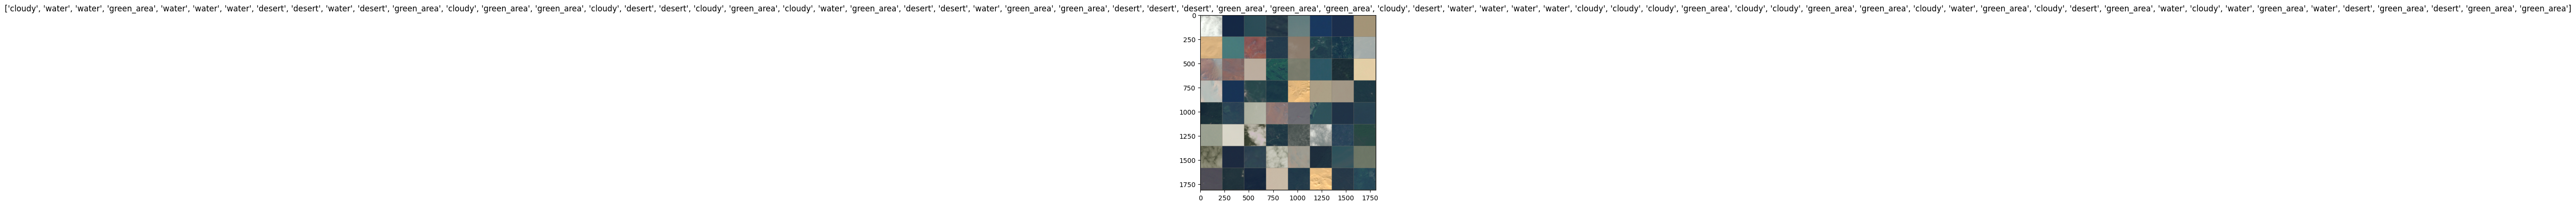

In [6]:
#Displaying Validation Images
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp +mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders['Validation']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

IMPORTING RESNET50
 MODEL

In [7]:
import torchvision.models as models

# Use models.resnet50() to access the model
model = models.resnet50(pretrained=True)
model.eval()

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

IMPORTING THE SGD OPTIMIZER

In [8]:
import torch.optim as optim
# Get parameters from the model you defined earlier (e.g., model)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

DEFINING LOSS FUNCTION

In [9]:
import torch.nn  as nn
criterion = nn.CrossEntropyLoss()

TRAINING LOOP FOR THE RESNET50
 MODEL

In [10]:
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)



                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
Training Loss: 0.9386 Acc: 0.8544
Validation Loss: 0.2345 Acc: 0.9113
Epoch 2/20
----------
Training Loss: 0.0709 Acc: 0.9774
Validation Loss: 0.0248 Acc: 0.9929
Epoch 3/20
----------
Training Loss: 0.0556 Acc: 0.9825
Validation Loss: 0.0246 Acc: 0.9920
Epoch 4/20
----------
Training Loss: 0.0486 Acc: 0.9838
Validation Loss: 0.0216 Acc: 0.9947
Epoch 5/20
----------
Training Loss: 0.0360 Acc: 0.9865
Validation Loss: 0.1057 Acc: 0.9521
Epoch 6/20
----------
Training Loss: 0.0218 Acc: 0.9925
Validation Loss: 0.0446 Acc: 0.9823
Epoch 7/20
----------
Training Loss: 0.0265 Acc: 0.9913
Validation Loss: 0.0344 Acc: 0.9894
Epoch 8/20
----------
Training Loss: 0.0224 Acc: 0.9918
Validation Loss: 0.0349 Acc: 0.9885
Epoch 9/20
----------
Training Loss: 0.0262 Acc: 0.9905
Validation Loss: 0.0437 Acc: 0.9840
Epoch 10/20
----------
Training Loss: 0.0203 Acc: 0.9925
Validation Loss: 0.0131 Acc: 0.9938
Epoch 11/20
----------
Training Loss: 0.0339 Acc: 0.9880
Validation Loss: 0.170

SAVING RESNET50 MODEL


In [11]:
torch.save(model.state_dict(),'model.pth')

IMPORTING PYTORCH'S PRUNING UTILITIES

In [12]:
from torch.nn.utils import prune


LOADING THE SAVED PRE-TRAINED RESNET 50

In [13]:
model = models.resnet50()
model.load_state_dict(torch.load('model.pth', weights_only= True))

<All keys matched successfully>

UNSTRUCTURED PRUNING

In [14]:
for name, module in model.named_modules():
  if isinstance(module, torch.nn.Conv2d):
    prune.l1_unstructured(module, name='weight', amount=0.2) #Pruning 20% of the weights

FINETUNING THE PRUNED MODEL

In [15]:
#Defining EarlyStopping
class EarlyStopping:
  def __init__(self, patience=5, verbose=False):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_loss = None

  def __call__(self,val_loss):
    if self.best_loss is None:
      self.best_loss = val_loss
    elif val_loss < self.best_loss:
      self.best_loss = val_loss
      self.counter =  0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        if self.verbose:
          print('Early stopping triggered')
          return True
        return False

In [16]:
# Define a new optimizer for the pruned model
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.01)

In [18]:
# Training Loop for the pruned model

def train_model(model, criterion, optimizer, num_epochs=15, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it improves on validation accuracy
            if phase == 'Validation':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

                # Check for early stopping condition based on validation loss
                if early_stopping(epoch_loss):
                    break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model with early stopping
model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
Training Loss: 0.0109 Acc: 0.9964
Validation Loss: 0.0067 Acc: 0.9973
Epoch 2/20
----------
Training Loss: 0.0113 Acc: 0.9958
Validation Loss: 0.0064 Acc: 0.9982
Epoch 3/20
----------
Training Loss: 0.0103 Acc: 0.9973
Validation Loss: 0.0056 Acc: 0.9982
Epoch 4/20
----------
Training Loss: 0.0117 Acc: 0.9967
Validation Loss: 0.0065 Acc: 0.9991
Epoch 5/20
----------
Training Loss: 0.0168 Acc: 0.9938
Validation Loss: 0.0065 Acc: 0.9982
Epoch 6/20
----------
Training Loss: 0.0098 Acc: 0.9967
Validation Loss: 0.0065 Acc: 0.9965
Epoch 7/20
----------
Training Loss: 0.0122 Acc: 0.9958
Validation Loss: 0.0078 Acc: 0.9973
Epoch 8/20
----------
Training Loss: 0.0111 Acc: 0.9973
Validation Loss: 0.0083 Acc: 0.9965
Early stopping triggered
Epoch 9/20
----------
Training Loss: 0.0112 Acc: 0.9964
Validation Loss: 0.0071 Acc: 0.9982
Early stopping triggered
Epoch 10/20
----------
Training Loss: 0.0102 Acc: 0.9980
Validation Loss: 0.0063 Acc: 0.9973
Early stopping triggered
Epoc

VISUALIZING TRAINING LOGS

In [19]:
# Unpruned Model Data
unpruned_epochs = list(range(1, 21))
unpruned_train_loss = [0.9386, 0.0709, 0.0556, 0.0486, 0.0360, 0.0218, 0.0265, 0.0224, 0.0262, 0.0203, 0.0339, 0.0225, 0.0200, 0.0280, 0.0213, 0.0171, 0.0189, 0.0190, 0.0136, 0.0137]
unpruned_val_loss = [0.2345, 0.0248, 0.0246, 0.0216, 0.1057, 0.0446, 0.0344, 0.0349, 0.0437, 0.0131, 0.1707, 0.0548, 0.0257, 0.0249, 0.0093, 0.0073, 0.0187, 0.0225, 0.0050, 0.0119]
unpruned_train_acc = [0.8544, 0.9774, 0.9825, 0.9838, 0.9865, 0.9925, 0.9913, 0.9918, 0.9905, 0.9925, 0.9880, 0.9925, 0.9933, 0.9920, 0.9920, 0.9960, 0.9942, 0.9938, 0.9956, 0.9964]
unpruned_val_acc = [0.9113, 0.9929, 0.9920, 0.9947, 0.9521, 0.9823, 0.9894, 0.9885, 0.9840, 0.9938, 0.9414, 0.9778, 0.9929, 0.9911, 0.9982, 0.9982, 0.9911, 0.9938, 1.0000, 0.9956]

# Pruned Model Data
pruned_epochs = list(range(1, 21))
pruned_train_loss = [0.0109, 0.0113, 0.0103, 0.0117, 0.0168, 0.0098, 0.0122, 0.0111, 0.0112, 0.0102, 0.0099, 0.0143, 0.0128, 0.0108, 0.0101, 0.0094, 0.0094, 0.0099, 0.0095, 0.0113]
pruned_val_loss = [0.0067, 0.0064, 0.0056, 0.0065, 0.0065, 0.0065, 0.0078, 0.0083, 0.0071, 0.0063, 0.0101, 0.0051, 0.0060, 0.0055, 0.0049, 0.0076, 0.0082, 0.0057, 0.0035, 0.0039]
pruned_train_acc = [0.9964, 0.9958, 0.9973, 0.9967, 0.9938, 0.9967, 0.9958, 0.9973, 0.9964, 0.9980, 0.9982, 0.9958, 0.9953, 0.9967, 0.9969, 0.9971, 0.9962, 0.9962, 0.9969, 0.9969]
pruned_val_acc = [0.9973, 0.9982, 0.9982, 0.9991, 0.9982, 0.9965, 0.9973, 0.9965, 0.9982, 0.9973, 0.9956, 0.9991, 0.9973, 0.9973, 0.9991, 0.9982, 0.9956, 0.9982, 1.0000, 1.0000]


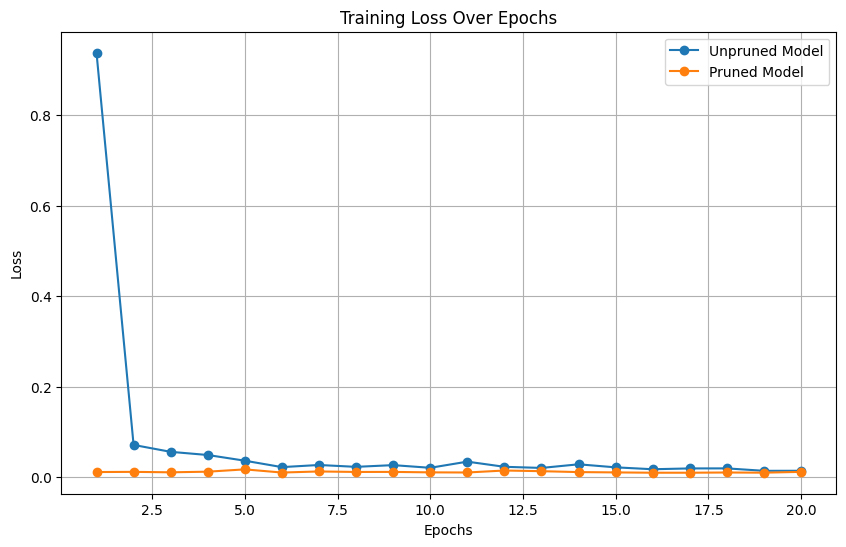

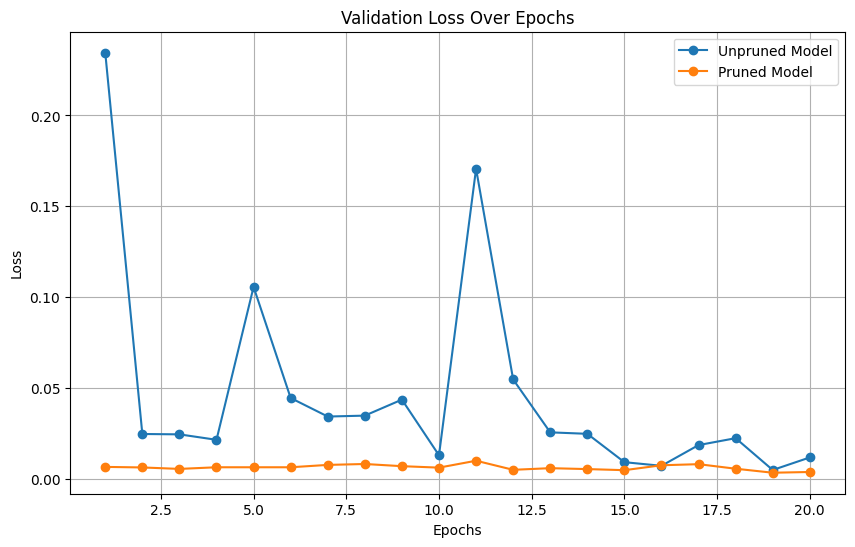

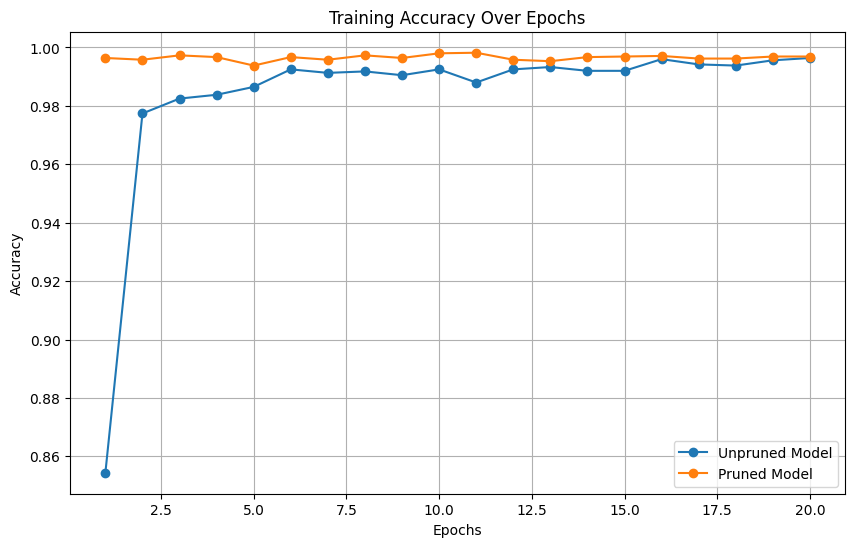

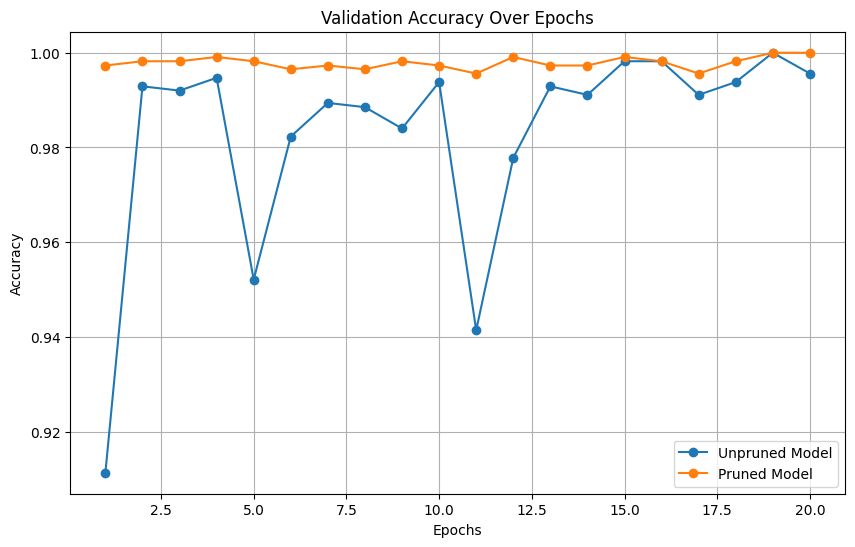

In [20]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(unpruned_epochs, unpruned_train_loss, label='Unpruned Model', marker='o')
plt.plot(pruned_epochs, pruned_train_loss, label='Pruned Model', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(unpruned_epochs, unpruned_val_loss, label='Unpruned Model', marker='o')
plt.plot(pruned_epochs, pruned_val_loss, label='Pruned Model', marker='o')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(10, 6))
plt.plot(unpruned_epochs, unpruned_train_acc, label='Unpruned Model', marker='o')
plt.plot(pruned_epochs, pruned_train_acc, label='Pruned Model', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(unpruned_epochs, unpruned_val_acc, label='Unpruned Model', marker='o')
plt.plot(pruned_epochs, pruned_val_acc, label='Pruned Model', marker='o')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
